In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import exoplanet as xo
from exoplanet.distributions import Angle

import pymc3_ext as pmx
#from celerite2.theano import terms, GaussianProcess

import astropy.units as u
from astropy import constants
from astropy.time import Time

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from sigfig import round

def get_median_sigma(pos):
    """
    Helper function to estimate median and sigma from posterior distribution
    Args:
        pos: array from posterior distribution
    Returns:
        (median,sigma): best fit value and 1 sigma uncertainty
    """
    temp = np.percentile(pos,[16,50,84])
    lower = temp[1]-temp[0]
    upper = temp[2]-temp[1]
    sigma = np.max([lower,upper])
    
    return (temp[1], sigma)

In [3]:
# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
rad_2_deg = 180 / np.pi
yr = 365.25


In [32]:
# parallax from Validation of the new Hipparcos reduction (2007). 
plx_hip = [22.27, 2.31]

# From our orbital solution
#plx_BaBb = [18.8,0.4]
plx_BaBb = [22.0,0.6]


# RV from our orbital solution of AaAb and BaBb (gamma_1 and gamma_2)

RV_A = pd.read_csv('RV_A.csv')
RV_B = pd.read_csv('RV_B.csv')

t_A = np.ascontiguousarray(RV_A["MJD"], dtype=float) + 2400000.5 # MJD to JD
rvA = np.ascontiguousarray(RV_A["A"], dtype=float) # km/s
rvA_err = np.ascontiguousarray(RV_A["A_err"], dtype=float) # km/s

t_B = np.ascontiguousarray(RV_B["MJD"], dtype=float) + 2400000.5 # MJD to JD
rvB = np.ascontiguousarray(RV_B["B"], dtype=float) # km/s
rvB_err = np.ascontiguousarray(RV_B["B_err"], dtype=float) # km/s

#rvB

In [122]:
# Read astrometry

astrometry_AB = pd.read_csv('AB_astrometry_2.csv')

# convert years to jds
astro_jds = Time(np.ascontiguousarray(astrometry_AB["date"]), format="byear").jd
astro_mjds = astro_jds - 2400000.5
rho_data = np.ascontiguousarray(astrometry_AB["sep"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astrometry_AB["sep_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astrometry_AB["pa"].to_numpy() * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astrometry_AB["pa_err"].to_numpy()  * deg, dtype=float)  # radians

astroAB_new = astrometry_AB[['date','sep','sep_err','pa','pa_err']]

astroAB_new.to_csv('astroAB_new.csv',index=False)



#pd.DataFrame(np.array([astro_mjds,rho_data,rho_err,theta_data, theta_err]).T, 
 #            columns=['MJD', 'rho','rho_err','PA','PA_err'])

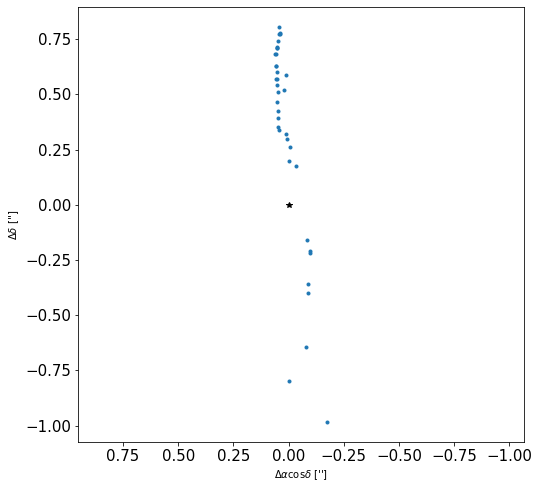

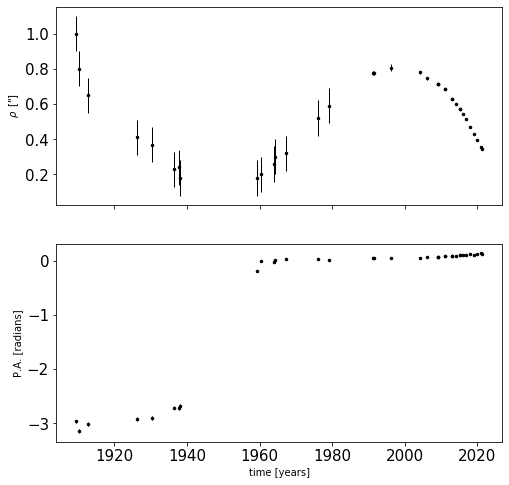

In [123]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(8, 8))

xd = rho_data * np.cos(theta_data) # X is north
yd = rho_data * np.sin(theta_data) # Y is east

ax.plot(yd, xd, ".")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
#ax.set_xlim(0.2, -0.2)
ax.set_aspect("equal", "datalim")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
ax[0].errorbar(astrometry_AB['date'], rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astrometry_AB['date'], theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

plt.show()

In [124]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun


def calc_a(Mtot, P):
    '''
    Calculate the semi-major axis using Kepler's third law 
    
    Args:
        Mtot (Msun) total mass 
        P (days) period
        
    Returns:
        a (au)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return (((Mtot / kg_to_M_sun) * constants.G.value * (P * day_to_s)**2) / (4 * np.pi**2))**(1/3) / au_to_m

def calc_K(Mtot, m_K, ecc,i,a):
    '''
    Calculate the RV semi-amplitude 
    
    Args:
        Mtot (Msun) total mass 
        m_K (Msun) mass for K (for K1 use M2 and for K2 use M1)
        ecc eccentricity
        i inclination
        a semi-major axis in AU
        
    Returns:
        K (km/s) semi-amplitude
    '''
    
    #day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    Kv = np.sqrt(constants.G.value/(1-ecc**2)) * m_K/kg_to_M_sun * np.sin(i) / (np.sqrt(Mtot/kg_to_M_sun) * np.sqrt(a*au_to_m))
    
    return Kv * (1 * u.meter / u.second).to(u.km / u.second).value


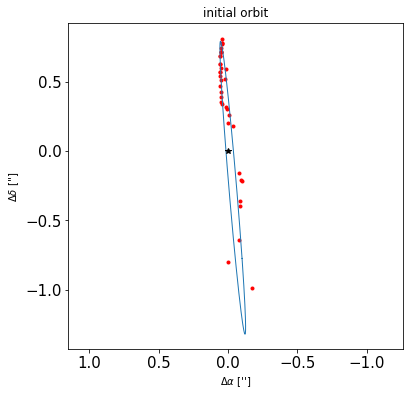

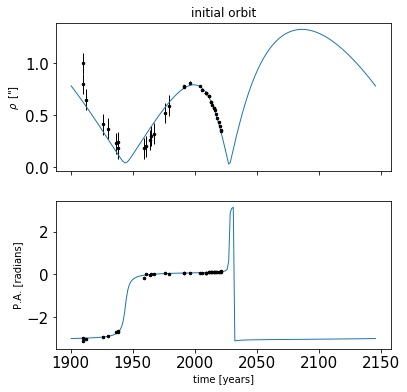

In [125]:
# Orbital elements from Kennedy 2019 

# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# For the relative astrometric fit, we only need the following parameters
a_ang_0 = 1.2  # arcsec
#parallax = 1  # arcsec (meaningless choice for now)
parallax = 23.7  # arcsec (meaningless choice for now)
a = a_ang_0 * au_to_R_sun / parallax
e_0 = 0.52
i_0 = 88.63 * deg  # [rad]
omega_0 = 64.67 * deg  # omega_1
Omega_0 = 4.60 * deg + np.pi
P_0 = 245.26 * yr  # days

T0 = Time(2023.0, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]
#T0 = 52481.34 + 2400000.5 # [Julian Date]

MB = 1.28


orbit = xo.orbits.KeplerianOrbit(
                a= a,
                t_periastron= T0,
                period= P_0,
                incl= i_0,
                ecc= e_0,
                omega= omega_0,
                Omega= Omega_0,
                m_planet=MB)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t_fine = np.linspace(T0 - P_0/2, T0 + P_0/2, num=200) 
rho, theta = theano.function([], orbit.get_relative_angles(t_fine, parallax))()

rv1 = theano.function([], conv * orbit.get_star_velocity(t_fine)[2])()
rv2 = theano.function([], conv * orbit.get_planet_velocity(t_fine)[2])()

#y_model, x_model, z_model = theano.function([], orbit.get_relative_position(astro_jds, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)


ax.scatter(yd, xd, marker=".", color ='r', label = 'Astrometry')
#ax.scatter(x_model*1000,y_model*1000)

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
#ax.legend(loc='upper left', prop={'size': 12})
#print(astrometry_PA[2])

t_fine_y = Time(np.ascontiguousarray(t_fine), format="jd").byear

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astrometry_AB['date'], rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t_fine_y, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astrometry_AB['date'], theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t_fine_y, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")


plt.show()

In [126]:
# for predicted orbits
t_fine_xy = t_fine = np.linspace(T0 - 150*yr, T0 + 150*yr, num=400) 

t_fine = t_fine = np.linspace(T0 - 200*yr, T0 + 200*yr, num=400) 

zeros = np.zeros_like(astro_jds)

# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=15,upper=30)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        #a_ang = pm.Uniform("a_ang", 0.005, 2, testval=a_ang_0)
        #a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 200 - 400 years,
        # so we'll set a broad prior on logP
        logP = pm.Uniform(
            "logP", lower=np.log(100 * yr), upper=np.log(500 * yr), testval=np.log(P_0)
        )
        
        P = pm.Deterministic("P", tt.exp(logP))
        
        

        omega = pm.Uniform("omega", lower= 0.0, upper= 2*np.pi, testval=omega_0)
        Omega = pm.Uniform("Omega", lower= np.pi, upper= 2*np.pi, testval=Omega_0)
        
        ecc = pm.Uniform("ecc", lower=0.01, upper=0.99, testval=e_0)
        
        # wide window around the last solution
        tp = pm.Uniform("tp", lower= Time(2000.0, format="byear").jd, 
                        upper= Time(2040.0, format="byear").jd, testval=T0)

        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval= np.cos(i_0))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        
        gamma = pm.Uniform("gamma", lower= 0, upper= 20, testval=  9.63)
        
        
        if parallax is not None:
            
            # From our orbital solution of BaBb and AaAb system 
            
            #MB = pm.Normal("MB", mu=1.49, sd=0.07, testval=1.49) # solar masses
            MB = pm.Normal("MB", mu=1.38, sd=0.5, testval=1.38) # solar masses

            #MA = pm.Normal("MA", mu=2.0, sd=0.1, testval=2.0) # solar masses
            MA = pm.Normal("MA", mu=1.22, sd=0.5, testval=1.22) # solar masses
            
            Mtot = pm.Deterministic("Mtot", MA + MB)
            
            # MB becomes a parameter, and then 'a' outer is calculated from Mtot and P
            a = pm.Deterministic("a", calc_a(Mtot, P))
            a_ang = pm.Deterministic("a_ang", a * plx)
            
            # Set up the orbit
            orbit = xo.orbits.KeplerianOrbit(
                a= a * au_to_R_sun,
                t_periastron= tp,
                period= P,
                incl= incl,
                ecc= ecc,
                omega= omega,
                Omega= Omega,
                m_planet=MB)
            
            # Set up the radial velocity model
            def model_rv1(t,offset):
                return conv * orbit.get_star_velocity(t)[2] + offset  #km/s
            
            def model_rv2(t,offset):
                return conv * orbit.get_planet_velocity(t)[2] + offset  #km/s
            
            rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx) # the rho, theta model values
            
            pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_err)
            pm.Deterministic('rho_diff',(rho_data-rho_model))
            
            # we need to calculate the difference 
            theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
            pm.Deterministic('theta_diff', theta_diff)
            
            pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_err)
            


        # RV jitter    
        logjit_outer = pm.Uniform("logjitterouter", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_ELO = pm.Uniform("logjitterouter_ELO", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_FEROS = pm.Uniform("logjitterouter_FEROS", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_FEROS2 = pm.Uniform("logjitterouter_FEROS2", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_CTIO = pm.Uniform("logjitterouter_CTIO", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_K19 = pm.Uniform("logjitterouter_K19", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        
        jit_outer = pm.Deterministic("jitouter", tt.exp(logjit_outer))
        jit_outer_ELO = pm.Deterministic("jitouter_ELO", tt.exp(logjit_outer_ELO))
        jit_outer_FEROS = pm.Deterministic("jitouter_FEROS", tt.exp(logjit_outer_FEROS))
        jit_outer_FEROS2 = pm.Deterministic("jitouter_FEROS2", tt.exp(logjit_outer_FEROS))
        jit_outer_CTIO = pm.Deterministic("jitouter_CTIO", tt.exp(logjit_outer_CTIO))
        jit_outer_K19 = pm.Deterministic("jitouter_K19", tt.exp(logjit_outer_K19))
        
        #
    
        # get the total errors
        def get_err(rv_err, logjitter):
            return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
            
        #Primary
        rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t_A,gamma))

        #Secondary
        rvmodel_b = pm.Deterministic("rvmodel_b", model_rv2(t_B,gamma))

        # Condition on the observations
        #TO95
        pm.Normal("obs_a_TO95", mu=rvmodel_a[0], sd=get_err(rvA_err[0], logjit_outer), observed=rvA[0])
        pm.Deterministic('OC_TOa', (rvmodel_a[0]-rvA[0]))
        pm.Normal("obs_b_TO95", mu=rvmodel_b[0], sd=get_err(rvB_err[0], logjit_outer), observed=rvB[0])
        pm.Deterministic('OC_TOb', (rvmodel_b[0]-rvB[0]))
        #ELODIE
        pm.Normal("obs_a_ELO", mu=rvmodel_a[1], sd=get_err(rvA_err[1], logjit_outer_ELO), observed=rvA[1])
        pm.Deterministic('OC_ELOa', (rvmodel_a[1]-rvA[1]))
        pm.Normal("obs_b_ELO", mu=rvmodel_b[1], sd=get_err(rvB_err[1], logjit_outer_ELO), observed=rvB[1])
        pm.Deterministic('OC_ELOb', (rvmodel_b[1]-rvB[1]))
        #FEROS
        pm.Normal("obs_a_FEROS", mu=rvmodel_a[2], sd=get_err(rvA_err[2], logjit_outer_FEROS), observed=rvA[2])
        pm.Deterministic('OC_FEROSa', (rvmodel_a[2]-rvA[2]))
        #FEROS2
        pm.Normal("obs_a_FEROS2", mu=rvmodel_a[4], sd=get_err(rvA_err[4], logjit_outer_FEROS2), observed=rvA[4])
        pm.Deterministic('OC_FEROSa2', (rvmodel_a[4]-rvA[4]))
        #K19
        pm.Normal("obs_a_K19", mu=rvmodel_b[2], sd=get_err(rvB_err[2], logjit_outer_K19), observed=rvB[2])
        pm.Deterministic('OC_K19b', (rvmodel_b[2]-rvB[2]))
        #CTIO
        pm.Normal("obs_a_CTIO", mu=rvmodel_a[3], sd=get_err(rvA_err[3], logjit_outer_CTIO), observed=rvA[3])
        pm.Deterministic('OC_CTIOa', (rvmodel_a[3]-rvA[3]))
        pm.Normal("obs_b_CTIO", mu=rvmodel_b[3], sd=get_err(rvB_err[3], logjit_outer_CTIO), observed=rvB[3])
        pm.Deterministic('OC_CTIOb', (rvmodel_b[3]-rvB[3]))
        
        #pm.Normal("obs_a", mu=rvmodel_a, sd=rvA_err, observed=rvA)
        #pm.Normal("obs_b", mu=rvmodel_b, sd=rvB_err, observed=rvB)
            
        
        
        # Set up predicted orbits for later plotting
        y_dense, x_dense, z_dense = orbit.get_relative_position(t_fine_xy, plx)
        x_save = pm.Deterministic("x_save", x_dense)
        y_save = pm.Deterministic("y_save", y_dense)
        
        # save some samples on a fine orbit for plotting purposes
        rho, theta = orbit.get_relative_angles(t_fine, plx)
        rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
        theta_save_sky = pm.Deterministic("thetaSaveSky", theta)
        
        rho, theta = orbit.get_relative_angles(astro_jds, plx)
        rho_save_data = pm.Deterministic("rhoSaveData", rho)
        theta_save_data = pm.Deterministic("thetaSaveData", theta)
        
        # save RV plots
        rv1_dense = pm.Deterministic("RV1Dense", model_rv1(t_fine,gamma))
        rv2_dense = pm.Deterministic("RV2Dense", model_rv2(t_fine,gamma))
        
        # RV semi-amplitude 
        K1 = pm.Deterministic("K1", calc_K(Mtot, MB, ecc, incl, a))
        K2 = pm.Deterministic("K2", calc_K(Mtot, MA, ecc, incl, a))

        # Optimize to find the initial parameters
        # Optimize the logp
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, [tp, omega, logP, MA, MB])
        map_soln = pmx.optimize(map_soln, [tp, omega, Omega, logP, MA, MB])
        map_soln = pmx.optimize(map_soln)


    return model, map_soln

#model, map_soln = get_model() 

model, map_soln = get_model(parallax=plx_BaBb) # With BaBb parallax results
#model, map_soln = get_model(parallax=plx_hip) # With BaBb parallax results

optimizing logp for variables: [MB, MA, logP, omega, tp]


message: Desired error not necessarily achieved due to precision loss.
logp: -177.832787816726 -> 108.40241159164925
optimizing logp for variables: [MB, MA, logP, Omega, omega, tp]


message: Optimization terminated successfully.
logp: 108.40241159164925 -> 113.11589235112034
optimizing logp for variables: [logjitterouter_K19, logjitterouter_CTIO, logjitterouter_FEROS2, logjitterouter_FEROS, logjitterouter_ELO, logjitterouter, MA, MB, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


message: Optimization terminated successfully.
logp: 113.11589235112034 -> 140.3526647523677


mass
1.3555921026026165
1.1082455086851317
22.287585278770003
2023.383696834286
224.7747626665856
1.112824320318799
8.824836789711739
184.5094683104799
65.89786439427345

4.085251715233405
3.339840838968689


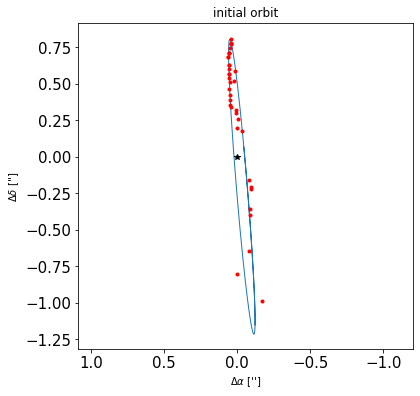

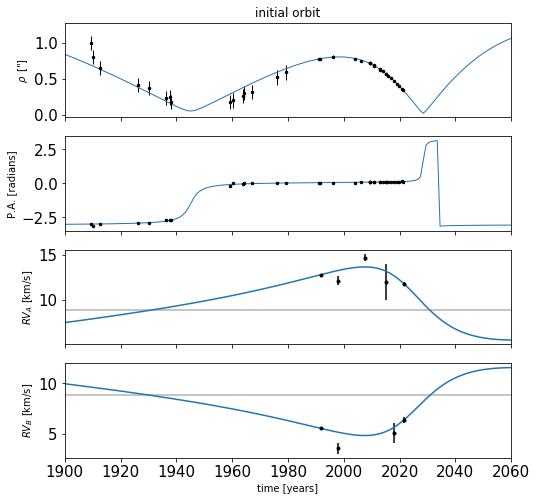

In [127]:
# Plot the orbit
print("mass")
print(map_soln['MB'])
print(map_soln['MA'])

#print(map_soln["offset_LA09"])
print(map_soln["m_plx"])
print(Time(map_soln["tp"], format="jd").byear)
print(map_soln["P"]/yr)
print(map_soln["a_ang"])

print(map_soln["gamma"])
print(map_soln["Omega"]*rad_2_deg)
print(map_soln["omega"]*rad_2_deg)
print("")
print(map_soln["K1"])
print(map_soln["K2"])

fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

xs = map_soln['x_save']  # X is north
ys = map_soln['y_save']  # Y is east
ax.plot(xs,ys, color="C0", lw=1)


ax.scatter(yd, xd, marker=".", color ='r', zorder=3)
#ax.scatter(x_model*1000,y_model*1000)

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
#ax.legend(loc='upper left', prop={'size': 12})
#print(astrometry_PA[2])

# Decimal year format
t_fine_y = Time(np.ascontiguousarray(t_fine), format="jd").byear

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
ax[0].errorbar(astrometry_AB['date'], rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t_fine_y, map_soln['rhoSaveSky'], color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astrometry_AB['date'], theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t_fine_y, map_soln['thetaSaveSky'], color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")

#offset_A = [map_soln["gamma_A"]+map_soln["offset_TO95"], map_soln["gamma_A"]+map_soln["offset_LA09"]]
#offset_B = [map_soln["gamma_B"]+map_soln["offset_TO95"], map_soln["gamma_B"]+map_soln["offset_LA09"]]

#offset_A = [0, map_soln["offset_LA09"]]
#offset_B = [0, map_soln["offset_LA09"]]

ax[2].axhline(map_soln['gamma'], color='k', alpha = 0.3)
ax[2].errorbar(Time(t_A, format="jd").byear, rvA, yerr = rvA_err,fmt=".k")
ax[2].plot(t_fine_y, map_soln["RV1Dense"], color="C0")
ax[2].set_ylabel(r"$RV_A$ [km/s]")
#plt.setp(ax[2],ylim=[0,16])(a * u.au)**(1/2)

ax[3].axhline(map_soln['gamma'], color='k', alpha = 0.3)
ax[3].errorbar(Time(t_B, format="jd").byear, rvB, yerr = rvB_err, fmt=".k")
ax[3].plot(t_fine_y, map_soln["RV2Dense"], color="C0")
ax[3].set_ylabel(r"$RV_B$ [km/s]")
_ = ax[3].set_xlabel("time [years]")
plt.setp(ax[3],xlim=[1900,2060])
#plt.setp(ax[3],ylim=[3,20])

plt.show()

In [128]:
#That looks fine, so now we can run the MCMC sampler:
np.random.seed(39091)
with model:
    trace = pmx.sample(
        tune=8000, draws=5000, start=map_soln, chains=4, cores=4, target_accept=0.9, init="adapt_full",
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterouter_K19, logjitterouter_CTIO, logjitterouter_FEROS2, logjitterouter_FEROS, logjitterouter_ELO, logjitterouter, MA, MB, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


Sampling 4 chains for 8_000 tune and 5_000 draw iterations (32_000 + 20_000 draws total) took 846 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [129]:
# Then we can look at some summaries of the trace and the constraints on some of the key parameters:
with model:
    summary = pm.summary(
        trace,
        var_names=["a_ang", "Omega", "omega", "incl", "tp", "P", "MA", "MB", "m_plx"],
        round_to=3
    )

summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_ang,1.1350,0.0770,0.9900,1.2770,0.0020,0.0020,1195.1410,1078.2250,1555.7640,441.3820,1.0020
Omega,3.2200,0.0020,3.2170,3.2240,0.0000,0.0000,8350.0890,8346.7380,8267.2220,7862.2280,1.0000
omega,1.1310,0.0960,0.9450,1.3040,0.0020,0.0010,2079.1660,2079.1660,1927.0030,646.1740,1.0020
incl,1.5370,0.0020,1.5330,1.5410,0.0000,0.0000,1773.6810,1769.4970,1721.0370,586.7390,1.0020
tp,2459976.0580,473.2340,2459030.6160,2460805.0720,10.4700,7.4050,2042.9120,2042.9120,2087.2610,711.1330,1.0010
P,84427.1980,7908.3970,69986.9610,99432.3940,234.3550,177.6090,1138.7540,991.9080,1557.7980,438.8220,1.0020
MA,1.1230,0.2910,0.5620,1.6760,0.0050,0.0040,3260.4880,3260.4880,3356.6260,1959.7120,1.0010
MB,1.3940,0.2920,0.8270,1.9440,0.0050,0.0040,3833.1720,3232.0170,3916.2570,2243.6070,1.0010
m_plx,22.1820,0.5240,21.1620,23.1230,0.0080,0.0050,4816.9770,4772.9380,4752.6700,5878.9080,1.0010


Period (years): 230$\pm$20
Tp (years): 2023$\pm$1
omega (deg): 65$\pm$6
Omega (deg): 184.5$\pm$0.1
i (deg): 88.1$\pm$0.1
a (arcsec): 1.13$\pm$0.08
e: 0.46$\pm$0.02
gamma (km/s): 8.8$\pm$0.7


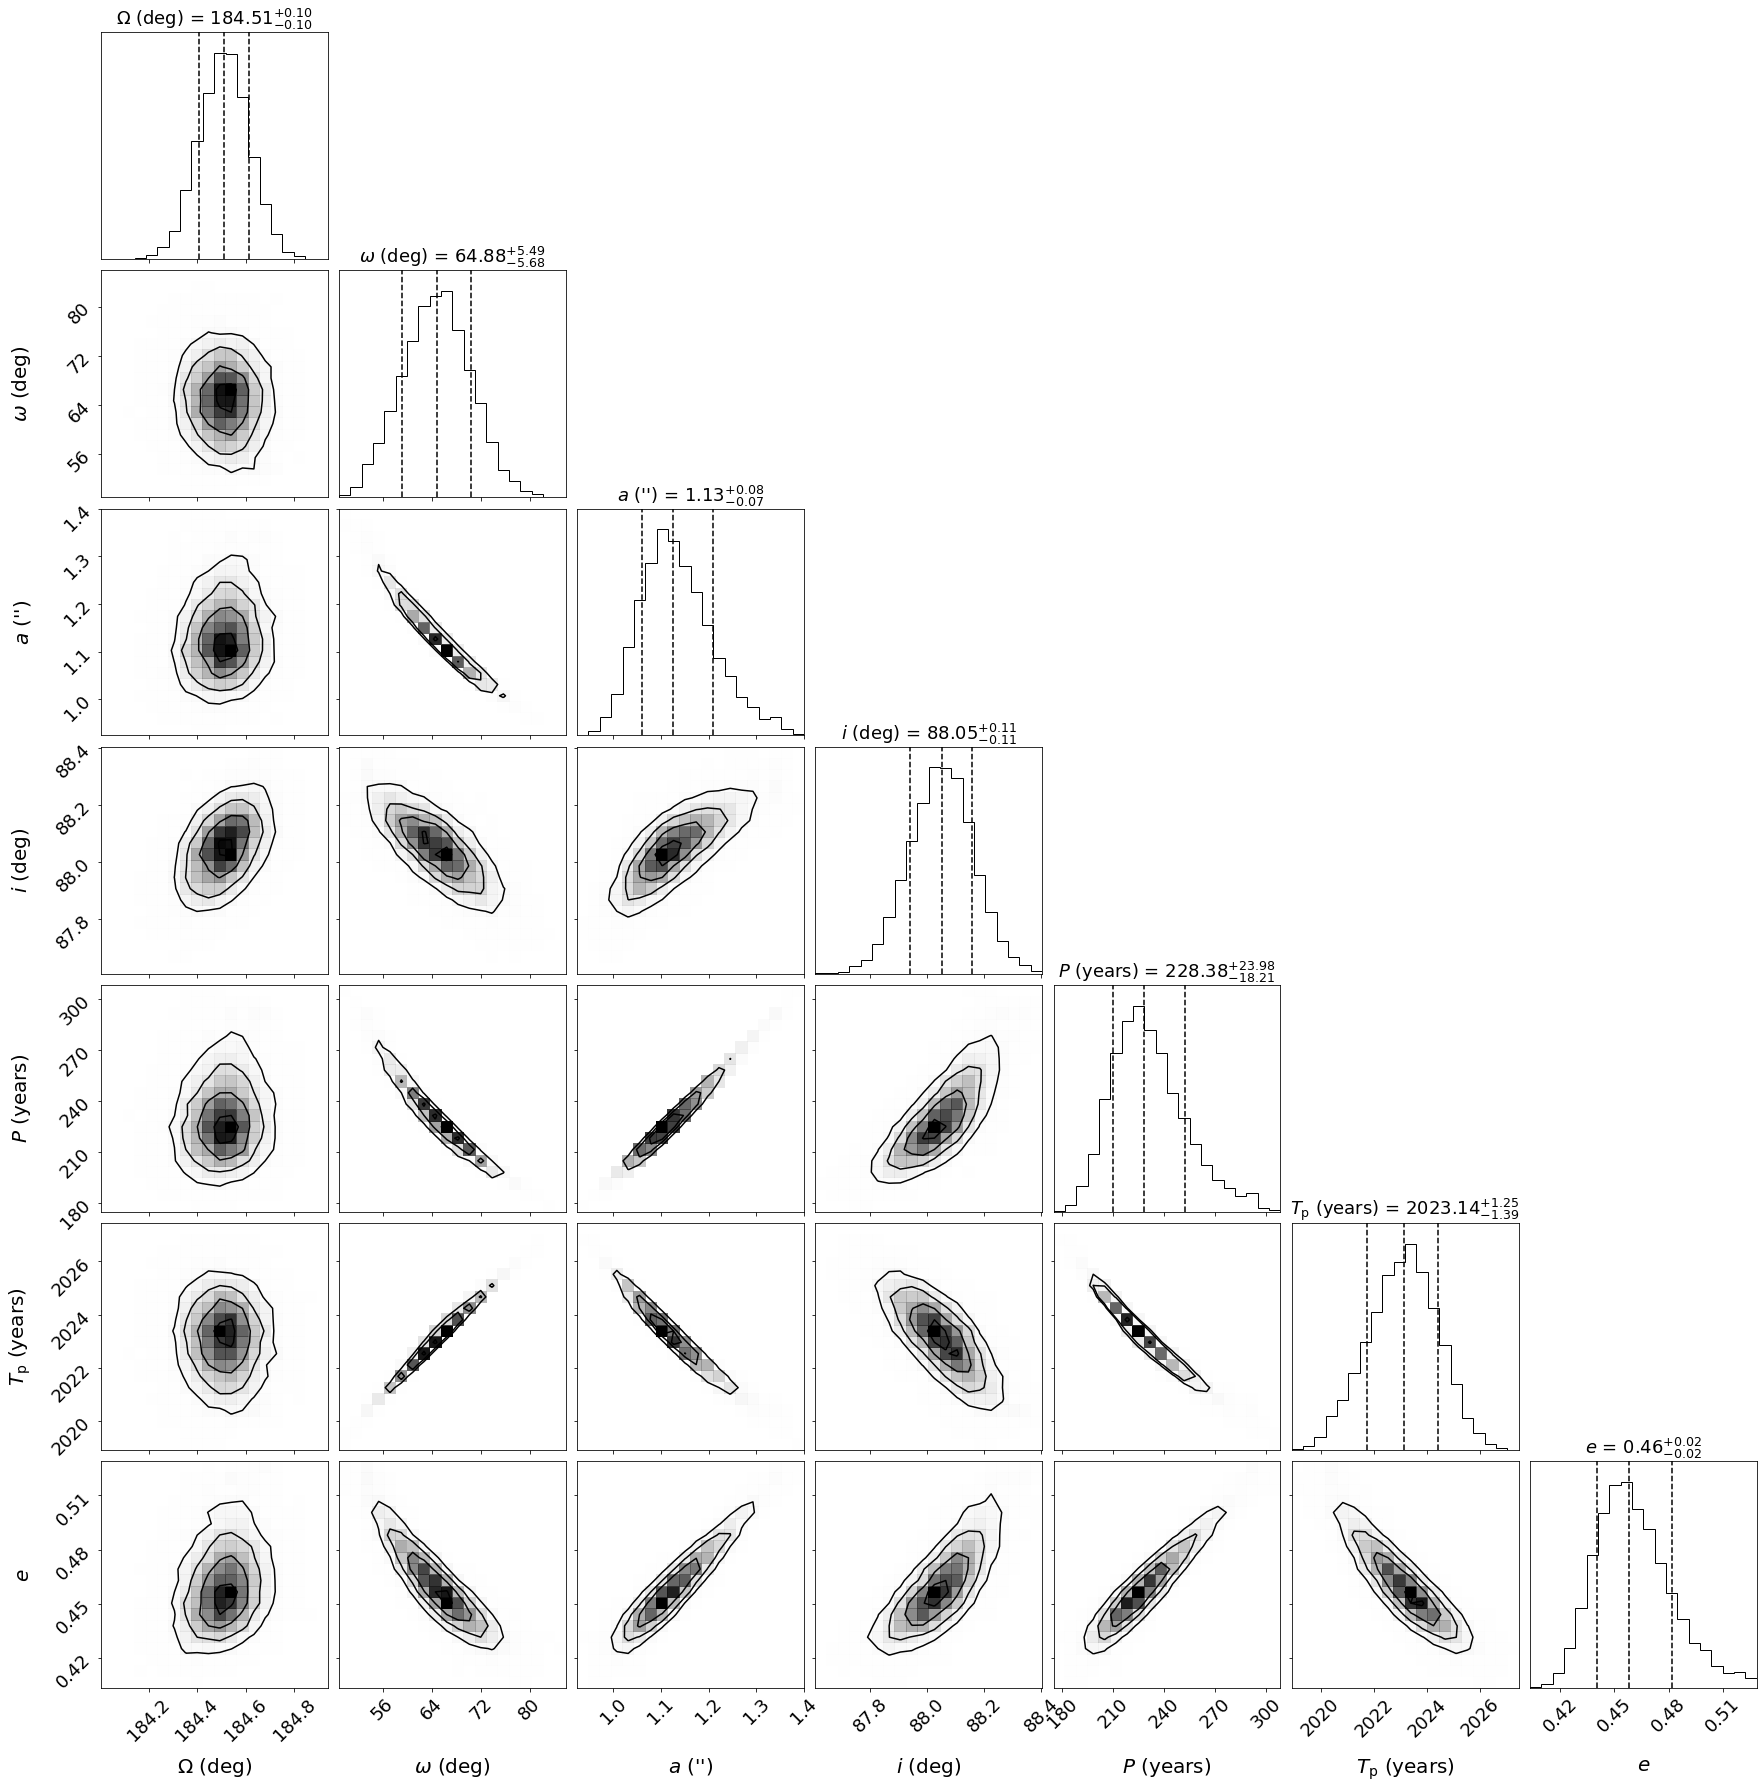

In [130]:
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
samples["$\Omega$ (deg)"] = (trace["Omega"] / deg) % 360
samples["$\omega$ (deg)"] = (trace["omega"] / deg) % 360
#samples["K1 [km/s]"] = (trace["K1"]) 
#samples["K2 [km/s]"] = (trace["K2"])
#samples["$\gamma$ [km/s]"] = (trace["gamma"])
samples["$a$ ('')"] = trace["a_ang"]
#samples["$\pi$ [mas]"] = trace["plx_save"]
samples["$i$ (deg)"] = (trace["incl"] / deg) % 360
samples["$P$ (years)"] = trace["P"] / yr
#samples["$f$"] = trace["f"]
samples["$T_\mathrm{p}$ (years)"] = Time(np.ascontiguousarray(trace["tp"]), format="jd").byear
#samples["$M1$ [$M_{\odot}$]"] = trace["M1_save"]
#samples["$M2$ [$M_{\odot}$]"] = trace["M2_save"]
samples["$e$"] = trace["ecc"]



period, period_s = get_median_sigma(samples["$P$ (years)"])
print("Period (years): "+round(str(period), uncertainty=str(period_s), separation='$\pm$'))

tp, tp_s = get_median_sigma(samples["$T_\mathrm{p}$ (years)"])
print("Tp (years): "+round(str(tp), uncertainty=str(tp_s), separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["omega"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), separation='$\pm$'))

Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), separation='$\pm$'))

inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
print("i (deg): "+round(str(inc), uncertainty=str(inc_s), separation='$\pm$'))

aang, aang_s = get_median_sigma(trace["a_ang"])
print("a (arcsec): "+round(str(aang), uncertainty=str(aang_s), separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["ecc"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))


del samples["Omega"]
figure = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 18}, label_kwargs=dict(fontsize=20), plot_datapoints=False)

figure.subplots_adjust(right=1.5,top=1.5)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=18)
    
xlim_min=tp-period
xlim_max=tp+period
    
#plt.savefig('AaAb_corner.pdf')  

figure.savefig('AB_corner.pdf',dpi=300,pad_inches=0.3,bbox_inches='tight')

In [132]:
samples.to_csv('Outer_posterior_large.csv', index=False)

M1: 1.1$\pm$0.3
M2: 1.4$\pm$0.3
K1 (km/s): 4.2$\pm$0.8
K2 (km/s): 3.3$\pm$0.8
plx (mas): 22.2$\pm$0.5
a (AU): 51$\pm$3
d (pc) : 45$\pm$1


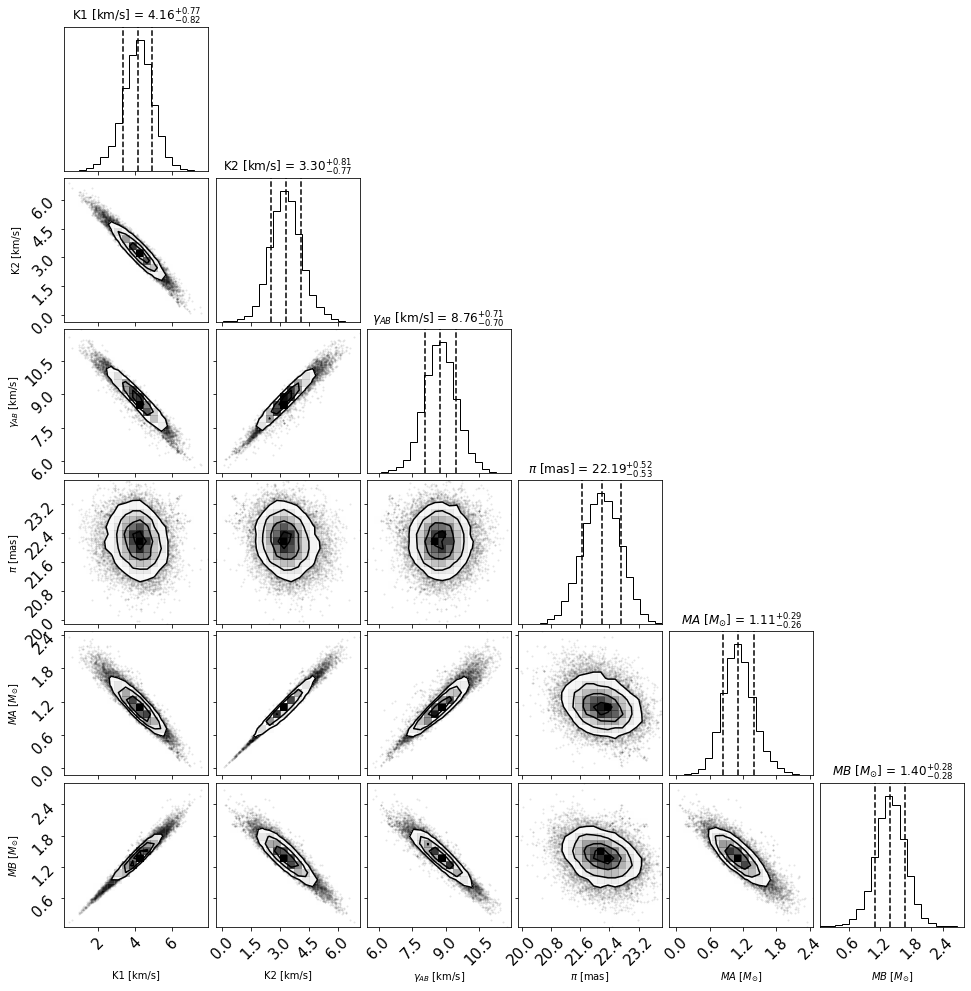

In [131]:
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
#samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
#samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["K1 [km/s]"] = (trace["K1"]) 
samples["K2 [km/s]"] = (trace["K2"])
samples["$\gamma_{AB}$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_A$ [km/s]"] = (trace["gamma_A"])
#samples["$\gamma_B$ [km/s]"] = (trace["gamma_B"])
#samples["${offset}_2$ [km/s]"] = (trace["offset_LA09"])
#samples["${offset}_1$ [km/s]"] = (trace["offset_TO95"])
#samples["$a$ [mas]"] = trace["a_ang"] * 1000
samples["$\pi$ [mas]"] = trace["m_plx"]
#samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
#samples["$P$ [d]"] = trace["P"]
samples["$MA$ [$M_{\odot}$]"] = trace["MA"]
samples["$MB$ [$M_{\odot}$]"] = trace["MB"]
#samples["$e$"] = trace["ecc"]

M1b, M1b_s = get_median_sigma(trace["MA"])
print("M1: "+round(str(M1b), uncertainty=str(M1b_s), separation='$\pm$'))

M2b, M2b_s = get_median_sigma(trace["MB"])
print("M2: "+round(str(M2b), uncertainty=str(M2b_s), separation='$\pm$'))

K1, K1_s = get_median_sigma(trace["K1"])
print("K1 (km/s): "+round(str(K1), uncertainty=str(K1_s), separation='$\pm$'))

K2, K2_s = get_median_sigma(trace["K2"])
print("K2 (km/s): "+round(str(K2), uncertainty=str(K2_s), separation='$\pm$'))

plxb, plxb_s = get_median_sigma(trace["m_plx"])
print("plx (mas): "+round(str(plxb), uncertainty=str(plxb_s), separation='$\pm$'))

ah, ah_s = get_median_sigma(trace["a"])
print("a (AU): "+round(str(ah), uncertainty=str(ah_s), separation='$\pm$'))

dist_pc, dist_pc_s = get_median_sigma(1/(trace["m_plx"]/1000))
print("d (pc) : "+round(str(dist_pc), uncertainty=str(dist_pc_s), separation='$\pm$'))

del samples["Omega"]

prior_dist = samples[["$\pi$ [mas]","$MA$ [$M_{\odot}$]","$MB$ [$M_{\odot}$]"]]

_ = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 12})

In [135]:
prior_dist.to_csv('mass_plx_large.csv', index=False)

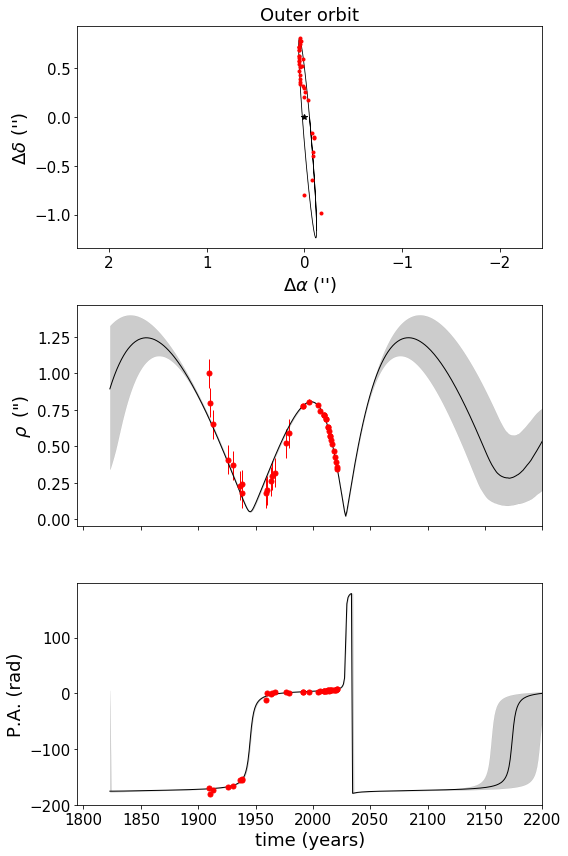

In [136]:
#errA = np.sqrt(rvA_err**2 + np.exp(2 * np.median(trace["logjitterouter"])))
#errB = np.sqrt(rvB_err**2 + np.exp(2 * np.median(trace["logjitterouter"])))


period = np.percentile(trace["P"], [16, 50, 84], axis=0)
gamma = np.percentile(trace["gamma"], [16, 50, 84], axis = 0)

theta_save = np.percentile(trace['thetaSaveSky'], [16, 50, 84], axis = 0)
rho_save = np.percentile(trace['rhoSaveSky'], [16, 50, 84], axis = 0)

RV1_save = np.percentile(trace['RV1Dense'], [16, 50, 84], axis = 0)
RV2_save = np.percentile(trace['RV2Dense'], [16, 50, 84], axis = 0)


qx = np.percentile(trace["x_save"], [16, 50, 84], axis=0)
qy = np.percentile(trace["y_save"], [16, 50, 84], axis=0)


# Plot the orbit
fig, ax = plt.subplots(nrows=3, sharex=False, figsize=(8, 12))

xs = qx[1]  # X is north
ys = qy[1]  # Y is east
ax[0].plot(xs,ys, color="k", lw=0.1)


ax[0].scatter(yd, xd, marker=".", color ='r', zorder=3)

# 1 sigma orbit range
#ax[0].fill(qx[2], qy[2], color="k", lw=0.2, alpha = 0.2)
#plt.fill(Rinner*rs[:,0], Rinner*rs[:,1], "White")
ax[0].plot(qx[1], qy[1], color="k", lw=0.8, zorder = 2)
#ax[0].plot(qx[2], qy[2], color="g", lw=0.8, zorder = 2)
#ax[0].plot(qx[0], qy[0], color="g", lw=0.8, zorder = 2)


ax[0].set_ylabel(r"$\Delta \delta$ ('')", fontsize=18)
ax[0].set_xlabel(r"$\Delta \alpha$ ('')", fontsize=18)
ax[0].invert_xaxis()
ax[0].plot(0, 0, "k*")
ax[0].set_aspect("equal", "datalim")
ax[0].set_title("Outer orbit", fontsize=18)
#ax.legend(loc='upper left', prop={'size': 12})
#print(astrometry_PA[2])
#plt.setp(ax[0],ylim=[-0.8,0.8])

plt.tight_layout()


# Decimal year format
t_fine_y = Time(np.ascontiguousarray(t_fine), format="jd").byear

ax[1].errorbar(astrometry_AB['date'], rho_data, yerr=rho_err, fmt="or", lw=1, ms=5)
ax[1].fill_between(t_fine_y, rho_save[0], rho_save[2], color="k", lw=0.2, alpha = 0.2)
ax[1].plot(t_fine_y, rho_save[1], color="k", lw=1)
ax[1].set_ylabel(r'$\rho\,$ (")', fontsize=18)
plt.setp(ax[1],xlim=[xlim_min,2200])
ax[1].tick_params(labelbottom=False)

ax[2].errorbar(astrometry_AB['date'], theta_data * rad_2_deg, yerr=theta_err * rad_2_deg, fmt="or", lw=1, ms=5)
ax[2].fill_between(t_fine_y, theta_save[0]*rad_2_deg, theta_save[2]*rad_2_deg, color="k", lw=0.2, alpha = 0.2)
ax[2].plot(t_fine_y, theta_save[1] * rad_2_deg, color="k", lw=1)
ax[2].set_ylabel(r"P.A. (rad)", fontsize=18)
_ = ax[2].set_xlabel("time (years)", fontsize=18)
plt.setp(ax[2],xlim=[xlim_min,2200])

plt.tight_layout()

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

#plt.savefig('AB_Orbit.pdf')  


plt.show()

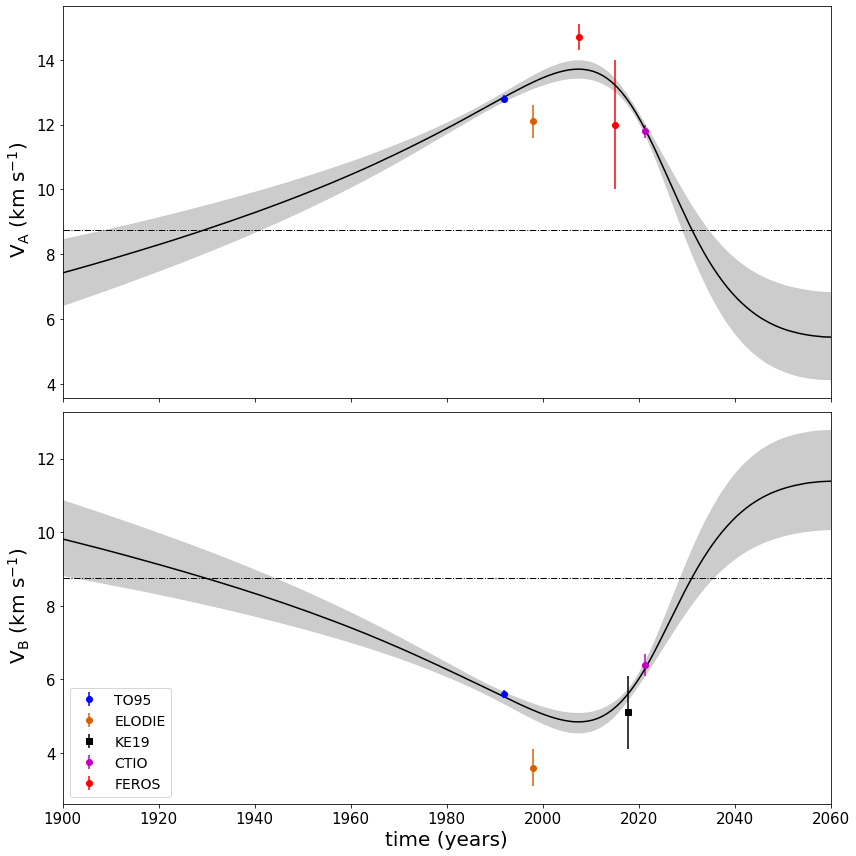

In [137]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 12))

ax[0].axhline(gamma[1], color='k', linestyle='dashdot', lw=1)
ax[0].errorbar(Time(t_A, format="jd").byear[0], rvA[0],yerr=rvA_err[0],
               fmt="ob", lw=1.5, ms=6, label='TO95')
ax[0].errorbar(Time(t_A, format="jd").byear[2], rvA[2],yerr=rvA_err[2],
               fmt="or", lw=1.5, ms=6, label='FEROS')
ax[0].errorbar(Time(t_A, format="jd").byear[4], rvA[4],yerr=rvA_err[4],
               fmt="or", lw=1.5, ms=6)
ax[0].errorbar(Time(t_A, format="jd").byear[3], rvA[3],yerr=rvA_err[3],
               fmt="om", lw=1.5, ms=6, label='CTIO')
ax[0].errorbar(Time(t_A, format="jd").byear[1], rvA[1],yerr=rvA_err[1],
               fmt="o", color="#d95f02", lw=1.5, ms=6, label='ELODIE')

ax[0].fill_between(t_fine_y, RV1_save[0], RV1_save[2], color="k", lw=0.2, alpha = 0.2)
ax[0].plot(t_fine_y, RV1_save[1], color="k")
ax[0].set_ylabel(r"$~\mathrm{V_A}$ ($\mathrm{km~s^{-1}}$)", fontsize=20)
#ax[0].legend(loc='lower center', prop={'size': 12})    

ax[1].axhline(gamma[1], color='k', linestyle='dashdot', lw=1)
ax[1].errorbar(Time(t_B, format="jd").byear[0], rvB[0],yerr=rvB_err[0],
               fmt="ob", lw=1.5, ms=6, label='TO95')
ax[1].errorbar(Time(t_B, format="jd").byear[1], rvB[1],yerr=rvB_err[1],
               fmt="o", color="#d95f02", lw=1.5, ms=6, label='ELODIE')
ax[1].errorbar(Time(t_B, format="jd").byear[2], rvB[2],yerr=rvB_err[2],
               fmt="sk", lw=1.5, ms=6, label='KE19')
ax[1].errorbar(Time(t_B, format="jd").byear[3], rvB[3],yerr=rvB_err[3],
               fmt="om", lw=1.5, ms=6, label='CTIO')
ax[1].errorbar(2065, 10,yerr=0, fmt="or", lw=1.5, ms=6, label='FEROS')

ax[1].legend(loc='lower left', prop={'size': 14})

ax[1].fill_between(t_fine_y, RV2_save[0], RV2_save[2], color="k", lw=0.2, alpha = 0.2)
ax[1].plot(t_fine_y, RV2_save[1], color="k")
ax[1].set_ylabel(r"$~\mathrm{V_B}$ ($\mathrm{km~s^{-1}}$)", fontsize=20)
_ = ax[1].set_xlabel("time (years)", fontsize=20)
plt.setp(ax[1],xlim=[1900,2060])

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)



plt.tight_layout()

#plt.savefig('AB_Orbit_RV.pdf')  


plt.show()

In [ ]:
#pd.options.display.float_format = '{:.4f}'.format
#np.set_printoptions(suppress=True)

#print(np.median(trace['OC_TOa']))
#print(np.median(trace['OC_ELOa']))
#print(np.median(trace['OC_FEROSa']))
#print(np.median(trace['OC_FEROSa2']))
#print(np.median(trace['OC_CTIOa']))
#print("")
#print(np.median(trace['OC_TOb']))
#print(np.median(trace['OC_ELOb']))
#print(np.median(trace['OC_K19b']))
#print(np.median(trace['OC_CTIOb']))
#print("")
#print(np.percentile(trace["rho_diff"], [16, 50, 84], axis = 0)[1])
#print("")
#print(np.percentile(trace["theta_diff"], [16, 50, 84], axis = 0)[1] * rad_2_deg)
#print(astro_sigma_maj)

In [139]:
# Read astrometry with small uncertainties

astrometry_AB = pd.read_csv('AB_astrometry_3.csv')

# convert years to jds
astro_jds = Time(np.ascontiguousarray(astrometry_AB["date"]), format="byear").jd
astro_mjds = astro_jds - 2400000.5
rho_data = np.ascontiguousarray(astrometry_AB["sep"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astrometry_AB["sep_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astrometry_AB["pa"].to_numpy() * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astrometry_AB["pa_err"].to_numpy()  * deg, dtype=float)  # radians

astroAB_new = astrometry_AB[['date','sep','sep_err','pa','pa_err']]

astroAB_new.to_csv('astroAB_Sol_II.csv',index=False)



#pd.DataFrame(np.array([astro_mjds,rho_data,rho_err,theta_data, theta_err]).T, 
 #            columns=['MJD', 'rho','rho_err','PA','PA_err'])


In [33]:
# for predicted orbits
t_fine_xy = t_fine = np.linspace(T0 - 250*yr, T0 + 250*yr, num=400) 

t_fine = t_fine = np.linspace(T0 - 200*yr, T0 + 200*yr, num=400) 

zeros = np.zeros_like(astro_jds)

# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=15,upper=30)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        #a_ang = pm.Uniform("a_ang", 0.005, 2, testval=a_ang_0)
        #a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 200 - 400 years,
        # so we'll set a broad prior on logP
        logP = pm.Uniform(
            "logP", lower=np.log(100 * yr), upper=np.log(600 * yr), testval=np.log(P_0)
        )
        
        P = pm.Deterministic("P", tt.exp(logP))
        
        

        omega = pm.Uniform("omega", lower= 0.0, upper= 2*np.pi, testval=omega_0)
        Omega = pm.Uniform("Omega", lower= np.pi, upper= 2*np.pi, testval=Omega_0)
        
        ecc = pm.Uniform("ecc", lower=0.01, upper=0.99, testval=e_0)
        
        # wide window around the last solution
        tp = pm.Uniform("tp", lower= Time(2000.0, format="byear").jd, 
                        upper= Time(2040.0, format="byear").jd, testval=T0)

        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval= np.cos(i_0))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        
        gamma = pm.Uniform("gamma", lower= 0, upper= 20, testval=  9.63)
        
        
        if parallax is not None:
            
            # From our orbital solution of BaBb and AaAb system 
            
            MB = pm.Normal("MB", mu=1.38, sd=0.5, testval=1.38) # solar masses

            MA = pm.Normal("MA", mu=1.22, sd=0.5, testval=1.22) # solar masses
            
            Mtot = pm.Deterministic("Mtot", MA + MB)
            
            # MB becomes a parameter, and then 'a' outer is calculated from Mtot and P
            a = pm.Deterministic("a", calc_a(Mtot, P))
            a_ang = pm.Deterministic("a_ang", a * plx)
            
            # Set up the orbit
            orbit = xo.orbits.KeplerianOrbit(
                a= a * au_to_R_sun,
                t_periastron= tp,
                period= P,
                incl= incl,
                ecc= ecc,
                omega= omega,
                Omega= Omega,
                m_planet=MB)
            
            # Set up the radial velocity model
            def model_rv1(t,offset):
                return conv * orbit.get_star_velocity(t)[2] + offset  #km/s
            
            def model_rv2(t,offset):
                return conv * orbit.get_planet_velocity(t)[2] + offset  #km/s
            
            rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx) # the rho, theta model values
            
            pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_err)
            
            # we need to calculate the difference 
            theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
            pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_err)
            

        # RV jitter    
        logjit_outer = pm.Uniform("logjitterouter", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_ELO = pm.Uniform("logjitterouter_ELO", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_FEROS = pm.Uniform("logjitterouter_FEROS", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_FEROS2 = pm.Uniform("logjitterouter_FEROS2", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_CTIO = pm.Uniform("logjitterouter_CTIO", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_outer_K19 = pm.Uniform("logjitterouter_K19", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        
        jit_outer = pm.Deterministic("jitouter", tt.exp(logjit_outer))
        jit_outer_ELO = pm.Deterministic("jitouter_ELO", tt.exp(logjit_outer_ELO))
        jit_outer_FEROS = pm.Deterministic("jitouter_FEROS", tt.exp(logjit_outer_FEROS))
        jit_outer_FEROS2 = pm.Deterministic("jitouter_FEROS2", tt.exp(logjit_outer_FEROS2))
        jit_outer_CTIO = pm.Deterministic("jitouter_CTIO", tt.exp(logjit_outer_CTIO))
        jit_outer_K19 = pm.Deterministic("jitouter_K19", tt.exp(logjit_outer_K19))
        
        #
    
        # get the total errors
        def get_err(rv_err, logjitter):
            return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
            
        #Primary
        rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t_A,gamma))

        #Secondary
        rvmodel_b = pm.Deterministic("rvmodel_b", model_rv2(t_B,gamma))

        # Condition on the observations
        #TO95
        pm.Normal("obs_a_TO95", mu=rvmodel_a[0], sd=get_err(rvA_err[0], logjit_outer), observed=rvA[0])
        pm.Normal("obs_b_TO95", mu=rvmodel_b[0], sd=get_err(rvB_err[0], logjit_outer), observed=rvB[0])
        #ELODIE
        pm.Normal("obs_a_ELO", mu=rvmodel_a[1], sd=get_err(rvA_err[1], logjit_outer_ELO), observed=rvA[1])
        pm.Normal("obs_b_ELO", mu=rvmodel_b[1], sd=get_err(rvB_err[1], logjit_outer_ELO), observed=rvB[1])
        #FEROS
        pm.Normal("obs_a_FEROS", mu=rvmodel_a[2], sd=get_err(rvA_err[2], logjit_outer_FEROS), observed=rvA[2])
        #FEROS2
        pm.Normal("obs_a_FEROS2", mu=rvmodel_a[4], sd=get_err(rvA_err[4], logjit_outer_FEROS2), observed=rvA[4])
        #K19
        pm.Normal("obs_a_K19", mu=rvmodel_b[2], sd=get_err(rvB_err[2], logjit_outer_K19), observed=rvB[2])
        #CTIO
        pm.Normal("obs_a_CTIO", mu=rvmodel_a[3], sd=get_err(rvA_err[3], logjit_outer_CTIO), observed=rvA[3])
        pm.Normal("obs_b_CTIO", mu=rvmodel_b[3], sd=get_err(rvB_err[3], logjit_outer_CTIO), observed=rvB[3])
        
        
        # Set up predicted orbits for later plotting
        y_dense, x_dense, z_dense = orbit.get_relative_position(t_fine_xy, plx)
        x_save = pm.Deterministic("x_save", x_dense)
        y_save = pm.Deterministic("y_save", y_dense)
        
        # save some samples on a fine orbit for plotting purposes
        rho, theta = orbit.get_relative_angles(t_fine, plx)
        rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
        theta_save_sky = pm.Deterministic("thetaSaveSky", theta)
        
        rho, theta = orbit.get_relative_angles(astro_jds, plx)
        rho_save_data = pm.Deterministic("rhoSaveData", rho)
        theta_save_data = pm.Deterministic("thetaSaveData", theta)
        
        # save RV plots
        rv1_dense = pm.Deterministic("RV1Dense", model_rv1(t_fine,gamma))
        rv2_dense = pm.Deterministic("RV2Dense", model_rv2(t_fine,gamma))
        
        # RV semi-amplitude 
        K1 = pm.Deterministic("K1", calc_K(Mtot, MB, ecc, incl, a))
        K2 = pm.Deterministic("K2", calc_K(Mtot, MA, ecc, incl, a))

        # Optimize to find the initial parameters
        # Optimize the logp
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, [tp, omega, logP, MA, MB])
        map_soln = pmx.optimize(map_soln, [tp, omega, Omega, logP, MA, MB])
        map_soln = pmx.optimize(map_soln)


    return model, map_soln

#model, map_soln = get_model() 

model, map_soln = get_model(parallax=plx_BaBb) # With BaBb parallax results


optimizing logp for variables: [MB, MA, logP, omega, tp]


message: Desired error not necessarily achieved due to precision loss.
logp: -484.85488654638107 -> 31.717227873209612
optimizing logp for variables: [MB, MA, logP, Omega, omega, tp]


message: Optimization terminated successfully.
logp: 31.717227873209612 -> 36.08928800202786
optimizing logp for variables: [logjitterouter_K19, logjitterouter_CTIO, logjitterouter_FEROS2, logjitterouter_FEROS, logjitterouter_ELO, logjitterouter, MA, MB, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: 36.08928800202786 -> 50.868960352641444


mass
1.4991178402903487
1.1587599569475864
22.431120825124047
2017.7531075728161
330.68993996769706
1.4858369871185222
8.65145665690393



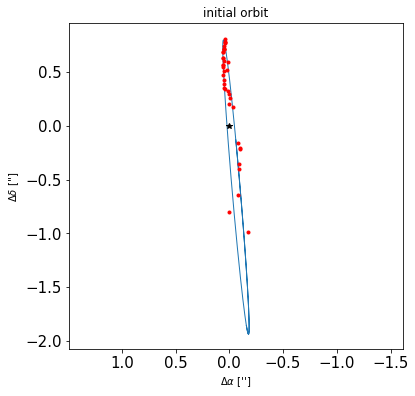

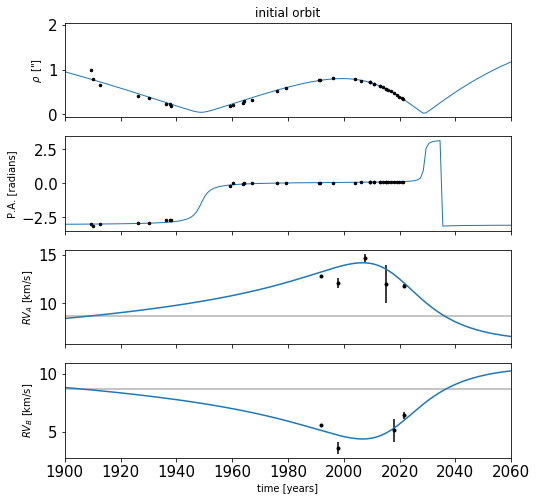

In [34]:
# Plot the orbit
print("mass")
print(map_soln['MB'])
print(map_soln['MA'])

#print(map_soln["offset_LA09"])
print(map_soln["m_plx"])
print(Time(map_soln["tp"], format="jd").byear)
print(map_soln["P"]/yr)
print(map_soln["a_ang"])

print(map_soln["gamma"])
print("")

fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

xs = map_soln['x_save']  # X is north
ys = map_soln['y_save']  # Y is east
ax.plot(xs,ys, color="C0", lw=1)


ax.scatter(yd, xd, marker=".", color ='r', zorder=3)
#ax.scatter(x_model*1000,y_model*1000)

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
#ax.legend(loc='upper left', prop={'size': 12})
#print(astrometry_PA[2])

# Decimal year format
t_fine_y = Time(np.ascontiguousarray(t_fine), format="jd").byear

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
ax[0].errorbar(astrometry_AB['date'], rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t_fine_y, map_soln['rhoSaveSky'], color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astrometry_AB['date'], theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t_fine_y, map_soln['thetaSaveSky'], color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")

#offset_A = [map_soln["gamma_A"]+map_soln["offset_TO95"], map_soln["gamma_A"]+map_soln["offset_LA09"]]
#offset_B = [map_soln["gamma_B"]+map_soln["offset_TO95"], map_soln["gamma_B"]+map_soln["offset_LA09"]]

#offset_A = [0, map_soln["offset_LA09"]]
#offset_B = [0, map_soln["offset_LA09"]]

ax[2].axhline(map_soln['gamma'], color='k', alpha = 0.3)
ax[2].errorbar(Time(t_A, format="jd").byear, rvA, yerr = rvA_err,fmt=".k")
ax[2].plot(t_fine_y, map_soln["RV1Dense"], color="C0")
ax[2].set_ylabel(r"$RV_A$ [km/s]")
#plt.setp(ax[2],ylim=[0,16])

ax[3].axhline(map_soln['gamma'], color='k', alpha = 0.3)
ax[3].errorbar(Time(t_B, format="jd").byear, rvB, yerr = rvB_err, fmt=".k")
ax[3].plot(t_fine_y, map_soln["RV2Dense"], color="C0")
ax[3].set_ylabel(r"$RV_B$ [km/s]")
_ = ax[3].set_xlabel("time [years]")
plt.setp(ax[3],xlim=[1900,2060])
#plt.setp(ax[3],ylim=[3,20])

plt.show()

In [35]:
#That looks fine, so now we can run the MCMC sampler:
np.random.seed(39091)
with model:
    trace = pmx.sample(
        tune=8000, draws=5000, start=map_soln, chains=4, cores=4, target_accept=0.99, init="adapt_full",
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterouter_K19, logjitterouter_CTIO, logjitterouter_FEROS2, logjitterouter_FEROS, logjitterouter_ELO, logjitterouter, MA, MB, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


Sampling 4 chains for 8_000 tune and 5_000 draw iterations (32_000 + 20_000 draws total) took 3226 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Period (years): 330$\pm$50
Tp (years): 2018$\pm$1
omega (deg): 44$\pm$4
Omega (deg): 184.6$\pm$0.1
i (deg): 88.39$\pm$0.09
a (arcsec): 1.5$\pm$0.2
e: 0.55$\pm$0.04
gamma (km/s): 8.8$\pm$0.9


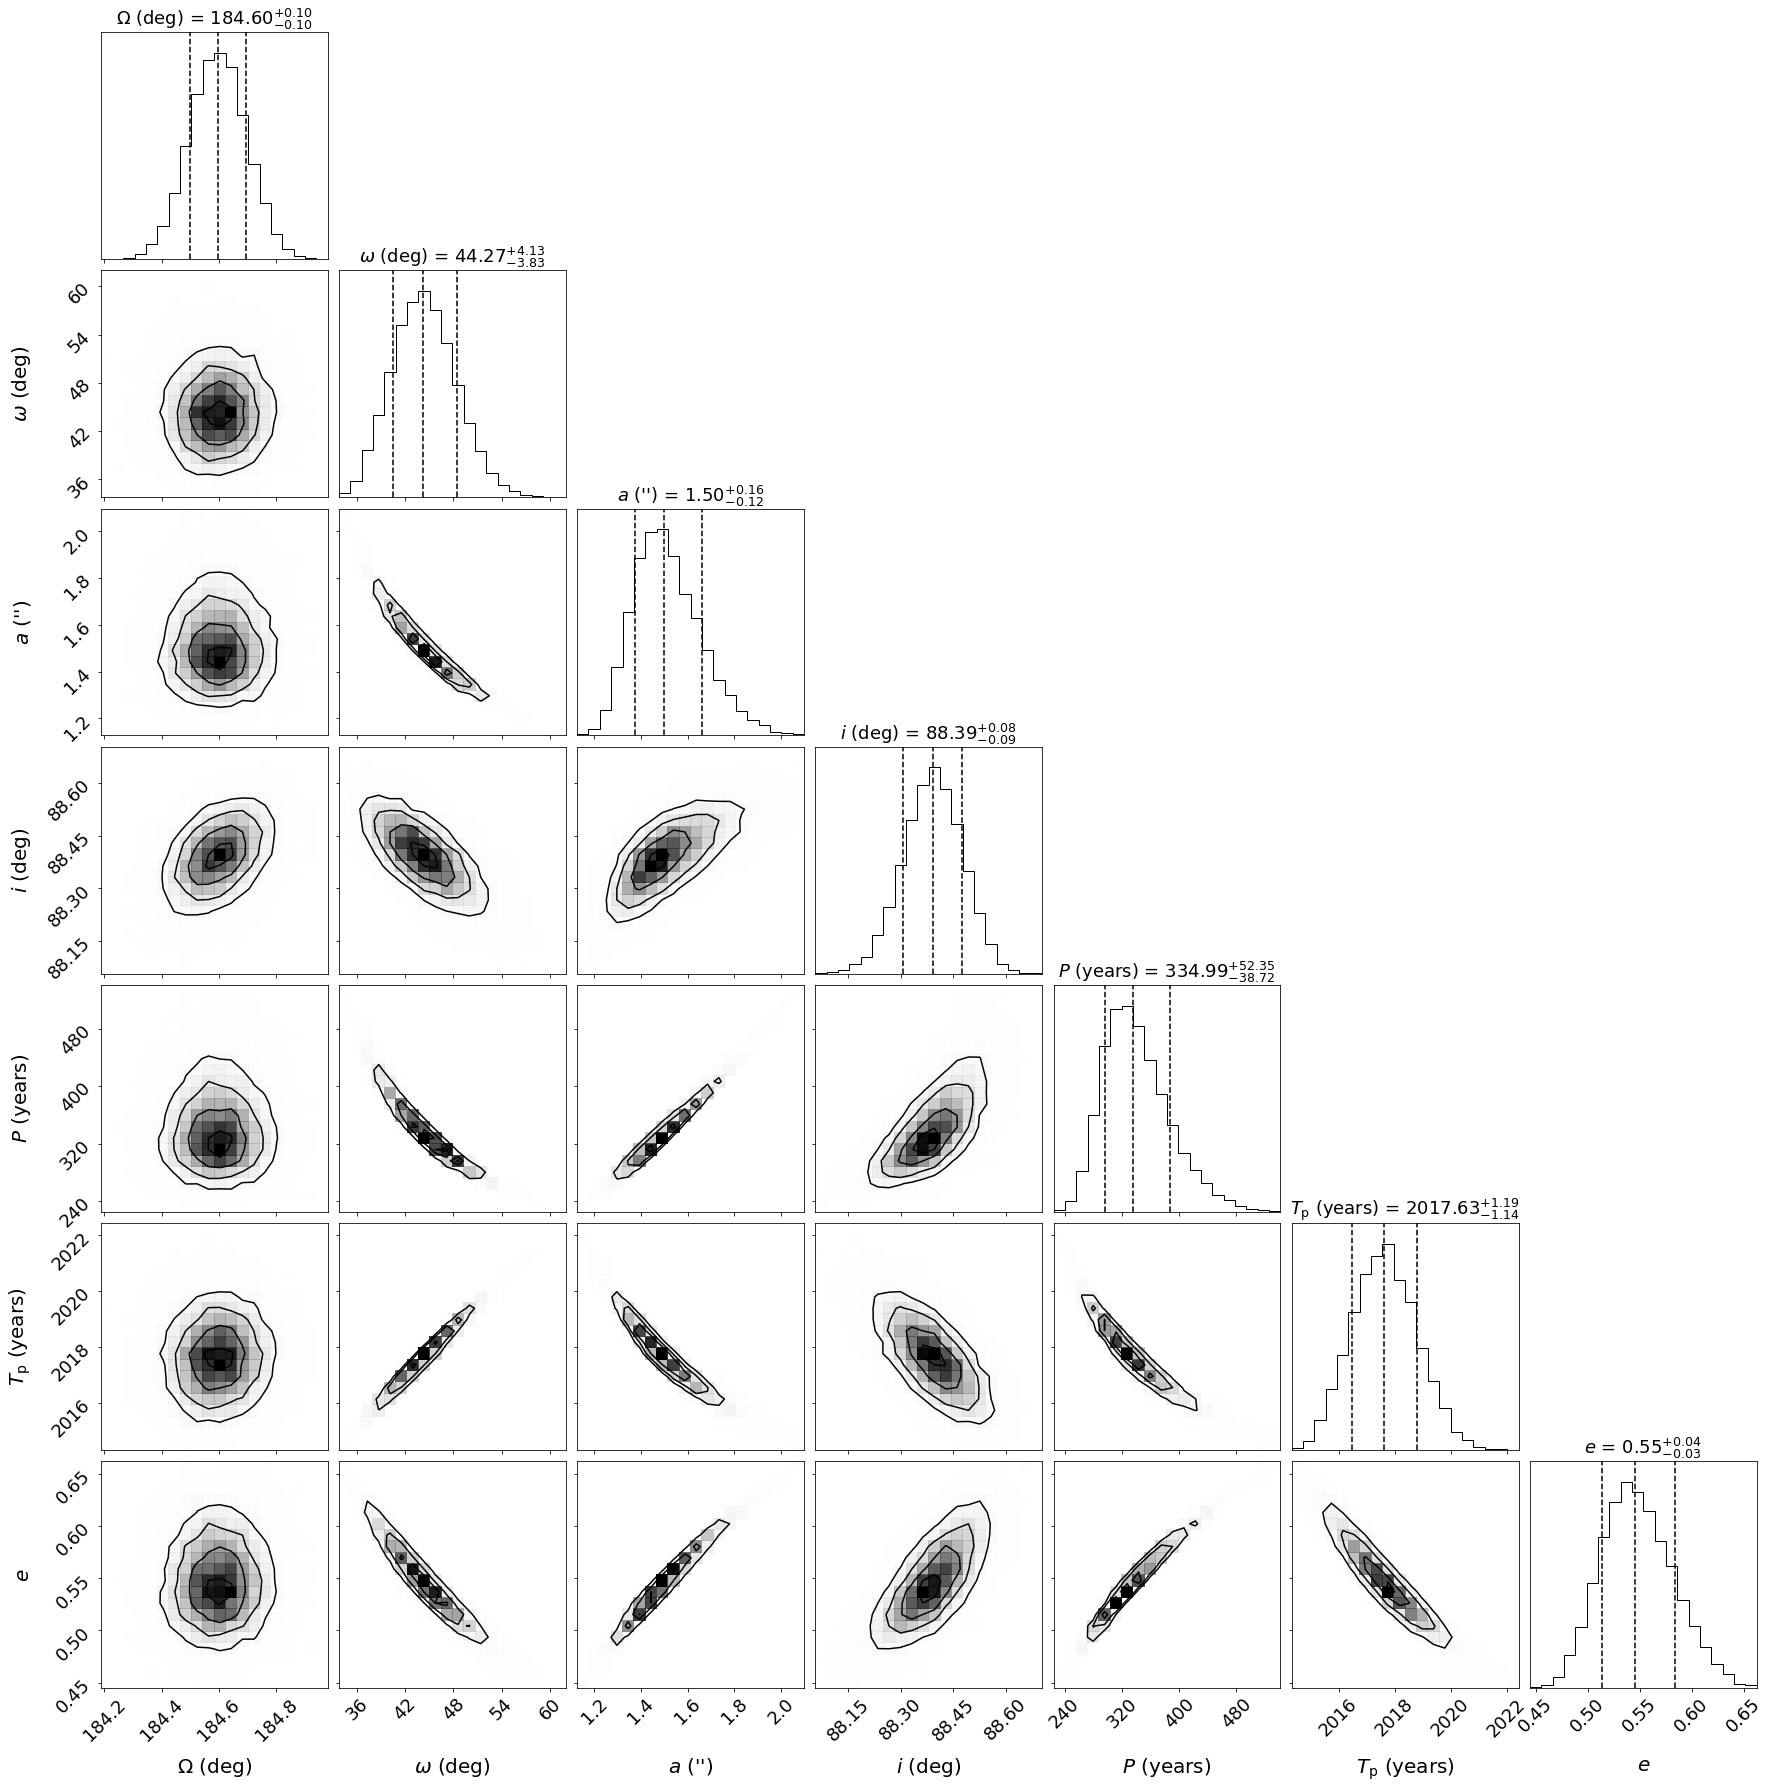

In [121]:
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
samples["$\Omega$ (deg)"] = (trace["Omega"] / deg) % 360
samples["$\omega$ (deg)"] = (trace["omega"] / deg) % 360
#samples["K1 [km/s]"] = (trace["K1"]) 
#samples["K2 [km/s]"] = (trace["K2"])
#samples["$\gamma$ [km/s]"] = (trace["gamma"])
samples["$a$ ('')"] = trace["a_ang"]
#samples["$\pi$ [mas]"] = trace["plx_save"]
samples["$i$ (deg)"] = (trace["incl"] / deg) % 360
samples["$P$ (years)"] = trace["P"] / yr
#samples["$f$"] = trace["f"]
samples["$T_\mathrm{p}$ (years)"] = Time(np.ascontiguousarray(trace["tp"]), format="jd").byear
#samples["$M1$ [$M_{\odot}$]"] = trace["M1_save"]
#samples["$M2$ [$M_{\odot}$]"] = trace["M2_save"]
samples["$e$"] = trace["ecc"]



period, period_s = get_median_sigma(samples["$P$ (years)"])
print("Period (years): "+round(str(period), uncertainty=str(period_s), separation='$\pm$'))

tp, tp_s = get_median_sigma(samples["$T_\mathrm{p}$ (years)"])
print("Tp (years): "+round(str(tp), uncertainty=str(tp_s), separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["omega"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), separation='$\pm$'))

Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), separation='$\pm$'))

inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
print("i (deg): "+round(str(inc), uncertainty=str(inc_s), separation='$\pm$'))

aang, aang_s = get_median_sigma(trace["a_ang"])
print("a (arcsec): "+round(str(aang), uncertainty=str(aang_s), separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["ecc"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))


del samples["Omega"]
figure = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 18}, label_kwargs=dict(fontsize=20), plot_datapoints=False)

figure.subplots_adjust(right=1.5,top=1.5)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=18)
    
xlim_min=tp-period
xlim_max=tp+period
    
#plt.savefig('AaAb_corner.pdf')  

figure.savefig('AB_corner_small.pdf',dpi=300,pad_inches=0.3,bbox_inches='tight')

samples.to_csv('Outer_posterior_small.csv', index=False)

M1: 1.3$\pm$0.4
M2: 1.4$\pm$0.4
K1 (km/s): 3.8$\pm$0.9
K2 (km/s): 3.3$\pm$0.9
plx (mas): 22.4$\pm$0.6
a (AU): 67$\pm$8
d (pc) : 45$\pm$1


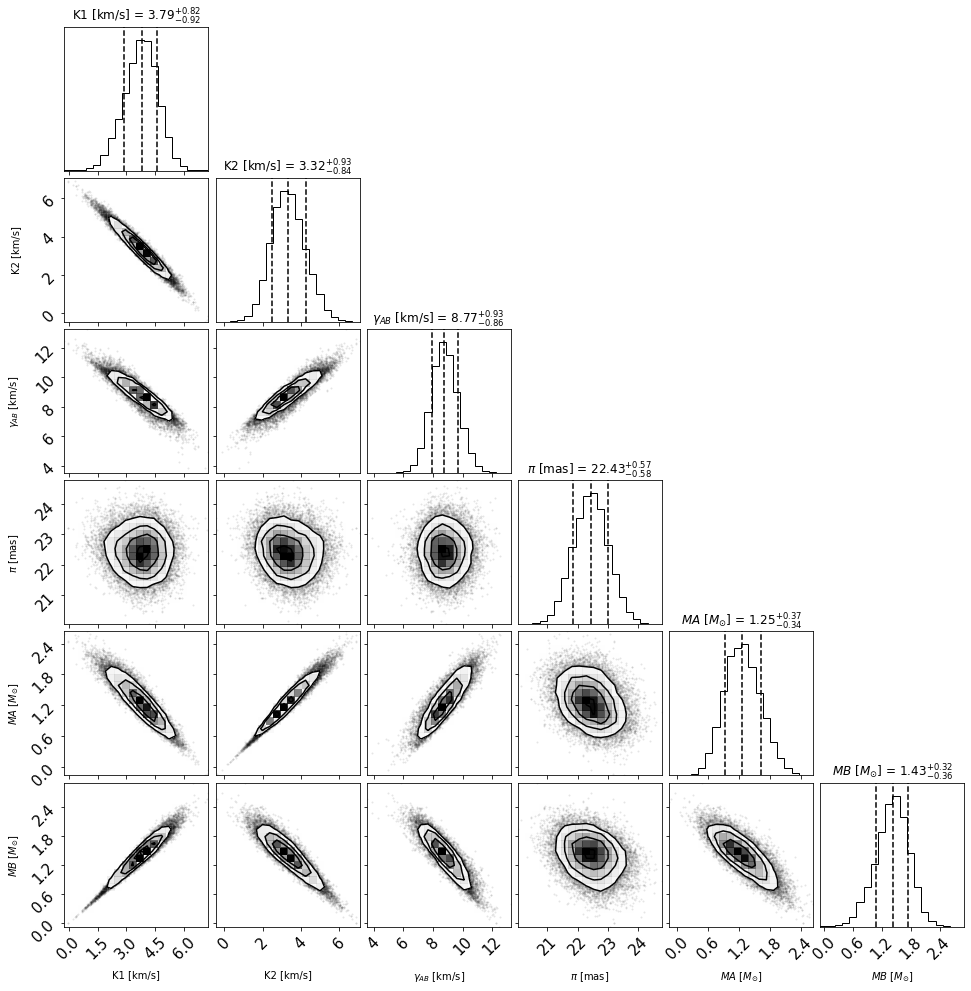

In [37]:
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
#samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
#samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["K1 [km/s]"] = (trace["K1"]) 
samples["K2 [km/s]"] = (trace["K2"])
samples["$\gamma_{AB}$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_A$ [km/s]"] = (trace["gamma_A"])
#samples["$\gamma_B$ [km/s]"] = (trace["gamma_B"])
#samples["${offset}_2$ [km/s]"] = (trace["offset_LA09"])
#samples["${offset}_1$ [km/s]"] = (trace["offset_TO95"])
#samples["$a$ [mas]"] = trace["a_ang"] * 1000
samples["$\pi$ [mas]"] = trace["m_plx"]
#samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
#samples["$P$ [d]"] = trace["P"]
samples["$MA$ [$M_{\odot}$]"] = trace["MA"]
samples["$MB$ [$M_{\odot}$]"] = trace["MB"]
#samples["$e$"] = trace["ecc"]

M1b, M1b_s = get_median_sigma(trace["MA"])
print("M1: "+round(str(M1b), uncertainty=str(M1b_s), separation='$\pm$'))

M2b, M2b_s = get_median_sigma(trace["MB"])
print("M2: "+round(str(M2b), uncertainty=str(M2b_s), separation='$\pm$'))

K1, K1_s = get_median_sigma(trace["K1"])
print("K1 (km/s): "+round(str(K1), uncertainty=str(K1_s), separation='$\pm$'))

K2, K2_s = get_median_sigma(trace["K2"])
print("K2 (km/s): "+round(str(K2), uncertainty=str(K2_s), separation='$\pm$'))

plxb, plxb_s = get_median_sigma(trace["m_plx"])
print("plx (mas): "+round(str(plxb), uncertainty=str(plxb_s), separation='$\pm$'))

ah, ah_s = get_median_sigma(trace["a"])
print("a (AU): "+round(str(ah), uncertainty=str(ah_s), separation='$\pm$'))

dist_pc, dist_pc_s = get_median_sigma(1/(trace["m_plx"]/1000))
print("d (pc) : "+round(str(dist_pc), uncertainty=str(dist_pc_s), separation='$\pm$'))

del samples["Omega"]

prior_dist = samples[["$\pi$ [mas]","$MA$ [$M_{\odot}$]","$MB$ [$M_{\odot}$]"]]

_ = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 12})

prior_dist.to_csv('mass_plx_small.csv', index=False)

In [38]:
# Read astrometry to show in plots

astrometry_AB = pd.read_csv('AB_astrometry_2.csv')

# convert years to jds
astro_jds = Time(np.ascontiguousarray(astrometry_AB["date"]), format="byear").jd
astro_mjds = astro_jds - 2400000.5
rho_data = np.ascontiguousarray(astrometry_AB["sep"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astrometry_AB["sep_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astrometry_AB["pa"].to_numpy() * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astrometry_AB["pa_err"].to_numpy()  * deg, dtype=float)  # radians

astroAB_new = astrometry_AB[['date','sep','sep_err','pa','pa_err']]

astroAB_new.to_csv('astroAB_Sol_I.csv',index=False)

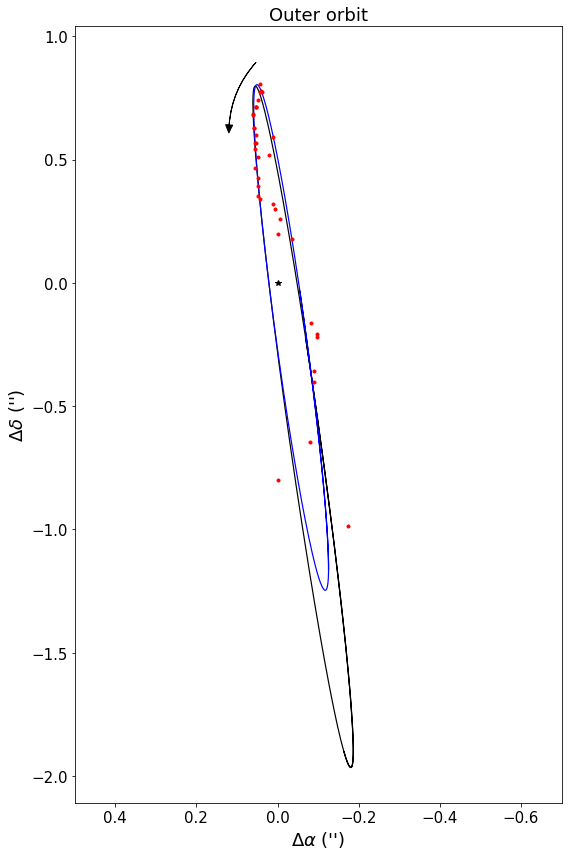

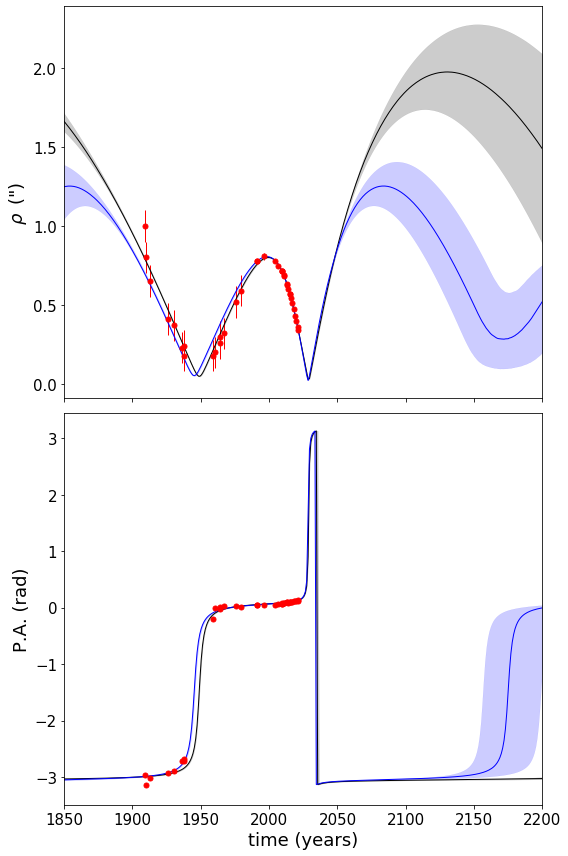

In [118]:
import matplotlib.patches as patches

errA = np.sqrt(rvA_err**2 + np.exp(2 * np.median(trace["logjitterouter"])))
errB = np.sqrt(rvB_err**2 + np.exp(2 * np.median(trace["logjitterouter"])))


period = np.percentile(trace["P"], [16, 50, 84], axis=0)
gamma = np.percentile(trace["gamma"], [16, 50, 84], axis = 0)

theta_save_1 = np.percentile(trace['thetaSaveSky'], [16, 50, 84], axis = 0)
rho_save_1 = np.percentile(trace['rhoSaveSky'], [16, 50, 84], axis = 0)

RV1_save_1 = np.percentile(trace['RV1Dense'], [16, 50, 84], axis = 0)
RV2_save_1 = np.percentile(trace['RV2Dense'], [16, 50, 84], axis = 0)


qx_1 = np.percentile(trace["x_save"], [16, 50, 84], axis=0)
qy_1 = np.percentile(trace["y_save"], [16, 50, 84], axis=0)


# Plot the orbit
fig, ax = plt.subplots(1,1, sharex=False, figsize=(8, 12))

xs = qx_1[1]  # X is north
ys = qy_1[1]  # Y is east
#ax.plot(xs,ys, color="k", lw=0.1)

style = "Simple, tail_width=0.05, head_width=7, head_length=8"
kw = dict(arrowstyle=style, color="k")

a3 = patches.FancyArrowPatch((0.05, 0.9), (0.12, 0.6),
                             connectionstyle="arc3,rad=0.2", **kw)
plt.gca().add_patch(a3)

ax.scatter(yd, xd, marker=".", color ='r', zorder=3)

# 1 sigma orbit range
#ax[0].fill(qx[2], qy[2], color="k", lw=0.2, alpha = 0.2)
#plt.fill(Rinner*rs[:,0], Rinner*rs[:,1], "White")
ax.plot(qx_1[1], qy_1[1], color="k", lw=1.2, zorder = 2)
ax.plot(qx[1], qy[1], color="b", lw=1.2, zorder = 2)
#ax.plot(xs, ys, color="b", lw=0.8, zorder = 2)
#ax[0].plot(qx[2], qy[2], color="g", lw=0.8, zorder = 2)
#ax[0].plot(qx[0], qy[0], color="g", lw=0.8, zorder = 2)


ax.set_ylabel(r"$\Delta \delta$ ('')", fontsize=18)
ax.set_xlabel(r"$\Delta \alpha$ ('')", fontsize=18)
ax.invert_xaxis()
ax.plot(0, 0, "k*")
#ax[0].set_aspect("equal", "datalim")
ax.set_title("Outer orbit", fontsize=18)
#ax.legend(loc='upper left', prop={'size': 12})
#print(astrometry_PA[2])
plt.setp(ax,xlim=[0.5,-0.7])

plt.tight_layout()

plt.savefig('AB_Orbit_Full.pdf') 

# Plot the orbit
fig, ax = plt.subplots(nrows=2, sharex=False, figsize=(8, 12))

# Decimal year format
t_fine_y = Time(np.ascontiguousarray(t_fine), format="jd").byear

ax[0].errorbar(astrometry_AB['date'], rho_data, yerr=rho_err, fmt="or", lw=1, ms=5)
ax[0].fill_between(t_fine_y, rho_save_1[0], rho_save_1[2], color="k", lw=0.2, alpha = 0.2)
ax[0].plot(t_fine_y, rho_save_1[1], color="k", lw=1)
ax[0].fill_between(t_fine_y, rho_save[0], rho_save[2], color="b", lw=0.2, alpha = 0.2)
ax[0].plot(t_fine_y, rho_save[1], color="b", lw=1)
ax[0].set_ylabel(r'$\rho\,$ (")', fontsize=18)
plt.setp(ax[0],xlim=[1850,2200])
ax[0].tick_params(labelbottom=False)

ax[1].errorbar(astrometry_AB['date'], theta_data, yerr=theta_err, fmt="or", lw=1, ms=5)
ax[1].fill_between(t_fine_y, theta_save_1[0], theta_save_1[2], color="k", lw=0.2, alpha = 0.2)
ax[1].plot(t_fine_y, theta_save_1[1], color="k", lw=1)
ax[1].fill_between(t_fine_y, theta_save[0], theta_save[2], color="b", lw=0.2, alpha = 0.2)
ax[1].plot(t_fine_y, theta_save[1], color="b", lw=1)
ax[1].set_ylabel(r"P.A. (rad)", fontsize=18)
_ = ax[1].set_xlabel("time (years)", fontsize=18)
plt.setp(ax[1],xlim=[1850,2200])

plt.tight_layout()

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.savefig('AB_Orbit_large.pdf')  


plt.show()

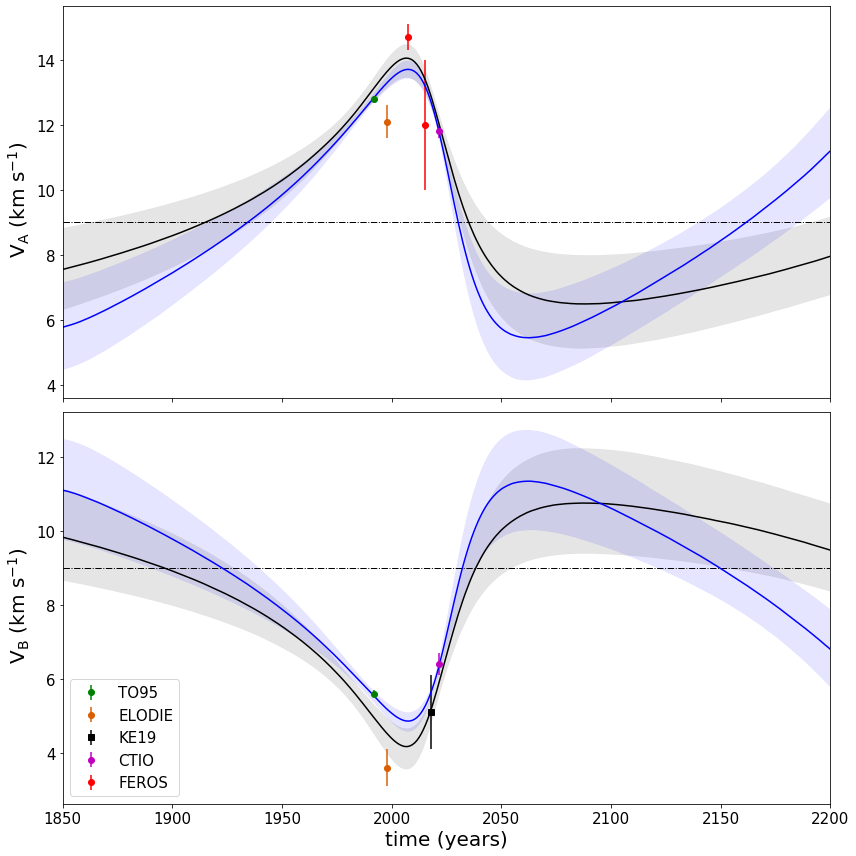

In [42]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 12))

#ax[0].axhline(gamma[1], color='k', linestyle='dashdot', lw=1)
ax[0].axhline(9.0, color='k', linestyle='dashdot', lw=1)

ax[0].errorbar(Time(t_A, format="jd").byear[0], rvA[0],yerr=rvA_err[0],
               fmt="og", lw=1.5, ms=6, label='TO95')
ax[0].errorbar(Time(t_A, format="jd").byear[1], rvA[1],yerr=rvA_err[1],
               fmt="o", color="#d95f02", lw=1.5, ms=6, label='ELODIE')
ax[0].errorbar(Time(t_A, format="jd").byear[2], rvA[2],yerr=rvA_err[2],
               fmt="or", lw=1.5, ms=6, label='FEROS')
ax[0].errorbar(Time(t_A, format="jd").byear[4], rvA[4],yerr=rvA_err[4],
               fmt="or", lw=1.5, ms=6)
ax[0].errorbar(Time(t_A, format="jd").byear[3], rvA[3],yerr=rvA_err[3],
               fmt="om", lw=1.5, ms=6, label='CTIO')

ax[0].fill_between(t_fine_y, RV1_save_1[0], RV1_save_1[2], color="k", lw=0.2, alpha = 0.1)
ax[0].fill_between(t_fine_y, RV1_save[0], RV1_save[2], color="b", lw=0.2, alpha = 0.1)
ax[0].plot(t_fine_y, RV1_save_1[1], color="k")
ax[0].plot(t_fine_y, RV1_save[1], color="b")
ax[0].set_ylabel(r"$~\mathrm{V_A}$ ($\mathrm{km~s^{-1}}$)", fontsize=20)
#ax[0].legend(loc='lower center', prop={'size': 12})    

#ax[1].axhline(gamma[1], color='k', linestyle='dashdot', lw=1)
ax[1].axhline(9.0, color='k', linestyle='dashdot', lw=1)


ax[1].errorbar(Time(t_B, format="jd").byear[0], rvB[0],yerr=rvB_err[0],
               fmt="og", lw=1.5, ms=6, label='TO95')
ax[1].errorbar(Time(t_B, format="jd").byear[1], rvB[1],yerr=rvB_err[1],
               fmt="o", color="#d95f02", lw=1.5, ms=6, label='ELODIE')
ax[1].errorbar(Time(t_B, format="jd").byear[2], rvB[2],yerr=rvB_err[2],
               fmt="sk", lw=1.5, ms=6, label='KE19')
ax[1].errorbar(Time(t_B, format="jd").byear[3], rvB[3],yerr=rvB_err[3],
               fmt="om", lw=1.5, ms=6, label='CTIO')
ax[1].errorbar(2300, 10,yerr=0, fmt="or", lw=1.5, ms=6, label='FEROS')

ax[1].legend(loc='lower left', prop={'size': 15})

ax[1].fill_between(t_fine_y, RV2_save_1[0], RV2_save_1[2], color="k", lw=0.2, alpha = 0.1)
ax[1].fill_between(t_fine_y, RV2_save[0], RV2_save[2], color="b", lw=0.2, alpha = 0.1)
ax[1].plot(t_fine_y, RV2_save_1[1], color="k")
ax[1].plot(t_fine_y, RV2_save[1], color="b")
ax[1].set_ylabel(r"$~\mathrm{V_B}$ ($\mathrm{km~s^{-1}}$)", fontsize=20)
_ = ax[1].set_xlabel("time (years)", fontsize=20)
plt.setp(ax[1],xlim=[1850,2200])

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)



plt.tight_layout()

plt.savefig('AB_Orbit_RV_large.pdf')  


plt.show()